In [1]:
import pandas as pd
import stanza
from bs4 import BeautifulSoup
import requests
from tqdm import tqdm
import random
import re
import os
from os.path import join
import math
import time
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import seaborn as sns
from langdetect import detect
from langcodes import *
import language_data
from collections import Counter

from nltk import word_tokenize,sent_tokenize,pos_tag
from nltk.stem import WordNetLemmatizer

from nltk.corpus import stopwords
import string
stopword_list = stopwords.words('english')
stopword_list.extend(['\'s','\'nt','’','``',"n't",'·','\'\'','...','“','\'m','\'ve','–','…'])
for mark in string.punctuation:
    stopword_list.append(mark)
    
import string
punctuation_marks = [char for char in string.punctuation]
    
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
#from nltk.sentiment.vader import SentimentIntensityAnalyzer

ana = SentimentIntensityAnalyzer()

In [2]:
greek_users = pd.read_csv('greek_users.tsv',sep='\t')
dutch_users = pd.read_csv('dutch_users.tsv',sep='\t')

## Create the corpus

In [3]:
corpus_dir = 'Corpus'

if not os.path.exists(corpus_dir):
    os.makedirs(corpus_dir)
    
reviews_dir = 'Reviews'

if not os.path.exists(reviews_dir):
    os.makedirs(reviews_dir)
    
cleaned_reviews_dir = 'Cleaned_reviews'

if not os.path.exists(cleaned_reviews_dir):
    os.makedirs(cleaned_reviews_dir)

The original reviews contain superfluous texts. These reviews are fitered. The full text of the reviews are saved in a directory named 'Cleaned_reviews'.

In [4]:
files = os.listdir(reviews_dir)
files = [file for file in files if not(re.search(r'^[.]',file))]

for file in files:
    full_text = ''
    path = join(reviews_dir,file)
    fh = open(path,encoding='utf-8')
    for review in fh:
        if not(re.search(r'^(.+)\'s review\s+[A-Z][a-z]{2}',review,re.IGNORECASE)):
            if re.search(r'\w+',review) and len(review.strip())>3:
                review = re.sub(r'\s+', ' ', review)
                full_text += review.strip()+'\n'
    with open(join(cleaned_reviews_dir,file),'w',encoding='utf-8') as out:
        out.write(full_text)

In [5]:
count = 0
sentence = ''
corpus = open(join(corpus_dir,'greek.txt'),'w',encoding='utf-8')

files = []
for i,row in greek_users.iterrows():
    path = join(cleaned_reviews_dir,f'{row["id"]}.txt')
    if os.path.isfile(path):
        files.append(path)
        
       
print(f"The reviews of {len(files)} Greek users have been downloaded.")

for file in tqdm(files):
    fh = open(file,encoding='utf-8')
    for review in fh:
        review = review.strip()
        review = re.sub(r'\s+',' ',review)
        try:
            language = detect(review)
        except:
            language = '[Unknown]'
            # The package cannot distinguish 
            # between Afrikaans and Dutch very well
        if language == 'af':
            language = 'nl'
        if language == 'en':
            count += 1
            corpus.write(f'{review}\n')

corpus.close()
print( f'They have written {count} reviews in English.' )


The reviews of 252 Greek users have been downloaded.


100%|█████████████████████████████████████████| 252/252 [01:02<00:00,  4.03it/s]

They have written 2737 reviews in English.


In [6]:
count = 0
corpus = open(join(corpus_dir,'dutch.txt'),'w',encoding='utf-8')

files = []
for i,row in dutch_users.iterrows():
    path = join(cleaned_reviews_dir,f'{row["id"]}.txt')
    if os.path.isfile(path):
        files.append(path)
        
print(f"The reviews of {len(files)} Dutch users have been downloaded.")

for file in tqdm(files):
    fh = open(file,encoding='utf-8')
    for review in fh:
        review = review.strip()
        review = re.sub(r'\s+',' ',review)
        try:
            language = detect(review)
        except:
            language = '[Unknown]'
 
            # The package cannot distinguish 
            # between Afrikaans and Dutch very well
        if language == 'af':
            language = 'nl'
        if language == 'en':
            count += 1
            corpus.write(f'{review}\n')

corpus.close()
print(f'\nThey have written {count} reviews in English.')

The reviews of 173 Dutch users have been downloaded.


100%|█████████████████████████████████████████| 173/173 [00:56<00:00,  3.08it/s]


They have written 2598 reviews in English.


## Analysis of vocabulary

In [7]:
reviews = open(join(corpus_dir,'dutch.txt'),encoding='utf-8')
full_text = reviews.read()
words = word_tokenize(full_text.lower())
#words = [word for word in words if word not in stopword_list]
print(f'The reviews by Dutch users contain {len(words)} words in total.')
dutch_freq = Counter(words)

reviews = open(join(corpus_dir,'greek.txt'),encoding='utf-8')
full_text = reviews.read()
words = word_tokenize(full_text.lower())
#words = [word for word in words if word not in stopword_list]
print(f'The reviews by Greek users contain {len(words)} words in total.')
greek_freq = Counter(words)

The reviews by Dutch users contain 355399 words in total.
The reviews by Greek users contain 317469 words in total.


## Make the subcorpora of equal length

In [8]:
max_length = 300000

reviews = open(join(corpus_dir,'greek.txt'),encoding='utf-8')

nr_tokens = 0
new_text = ''
full_text = reviews.read()
sentences = sent_tokenize(full_text)
for sentence in sentences:
    words = word_tokenize(sentence)
    nr_tokens += len(words)
    if nr_tokens < max_length:
        new_text += sentence + ' '
    else:
        print(f'Greek corpus contains {nr_tokens} tokens.')
        break
        
with open(join(corpus_dir,'greek_max_tokens.txt'),'w',encoding='utf-8') as out:
    out.write(new_text)
    

reviews = open(join(corpus_dir,'dutch.txt'),encoding='utf-8')

nr_tokens = 0
new_text = ''
full_text = reviews.read()
sentences = sent_tokenize(full_text)
for sentence in sentences:
    words = word_tokenize(sentence)
    nr_tokens += len(words)
    if nr_tokens < max_length:
        new_text += sentence + ' '
    else:
        print(f'Dutch corpus contains {nr_tokens} tokens.')
        break
        
with open(join(corpus_dir,'dutch_max_tokens.txt'),'w',encoding='utf-8') as out:
    out.write(new_text)

Greek corpus contains 300000 tokens.
Dutch corpus contains 300018 tokens.


In [9]:
reviews = open(join(corpus_dir,'dutch_max_tokens.txt'),encoding='utf-8')
full_text = reviews.read()
words = word_tokenize(full_text.lower())
words = [word for word in words if word not in stopword_list]
dutch_freq = Counter(words)

reviews = open(join(corpus_dir,'greek_max_tokens.txt'),encoding='utf-8')
full_text = reviews.read()
words = word_tokenize(full_text.lower())
words = [word for word in words if word not in stopword_list]
greek_freq = Counter(words)

In [10]:
for word,count in dutch_freq.most_common(30):
    print(word,count)

book 3079
read 1242
like 1002
one 894
story 813
really 665
also 634
life 630
much 623
time 578
would 575
way 574
love 569
reading 542
first 464
even 462
good 455
characters 450
people 425
still 412
think 411
novel 407
could 401
get 401
books 400
world 382
many 364
interesting 363
little 338
know 320


In [11]:
for word,count in greek_freq.most_common(30):
    print(word,count)

book 2603
read 1446
like 1202
one 1094
story 1005
really 987
love 781
characters 696
much 657
reading 605
way 589
even 580
would 574
good 569
books 544
time 540
loved 523
first 522
well 514
could 472
life 472
plot 463
also 454
get 440
think 440
great 438
know 424
people 405
things 377
end 370


In [12]:
common_words = []

for word,count in greek_freq.most_common(50):
    common_words.append(word)
    
for word,count in dutch_freq.most_common(50):
    common_words.append(word)
    
common_words = list(set(common_words))

words_to_remove = ['book','books','read','like']

for word in words_to_remove:
    if word in common_words:
        common_words.remove(word)


In [13]:
x_axis = []
y_axis = []
labels = []

for term in common_words:
    if greek_freq.get(term,0)<850 and dutch_freq.get(term,0)<850:
        x_axis.append(greek_freq.get(term,0))
        y_axis.append(dutch_freq.get(term,0))
        labels.append(term)

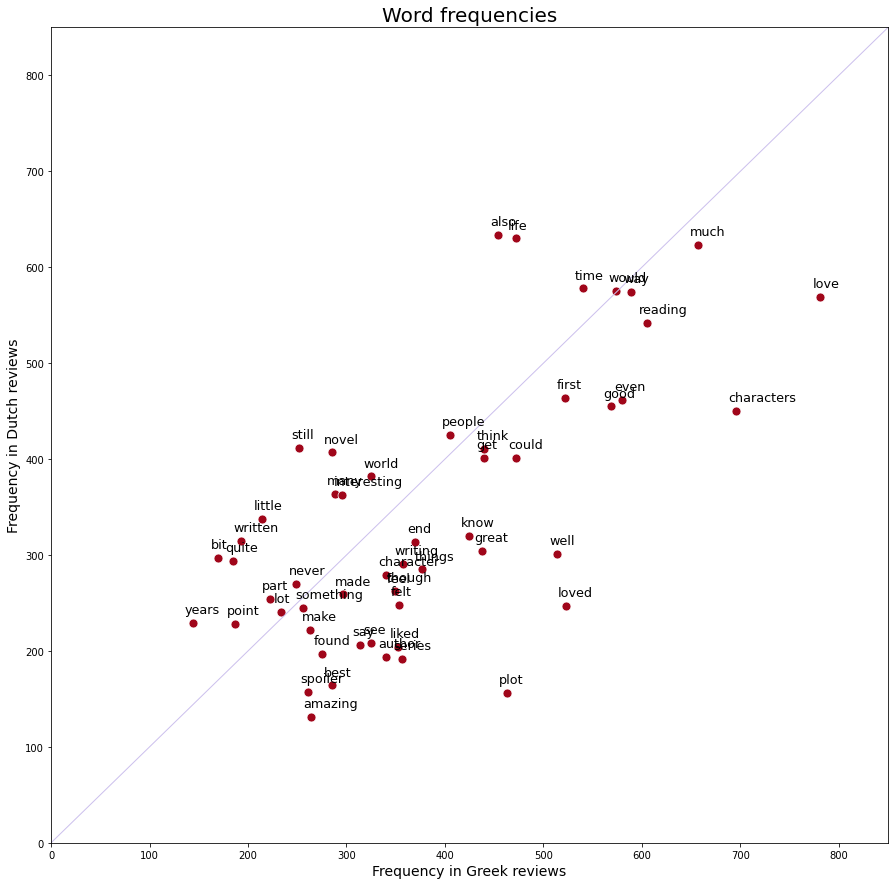

In [14]:
fig = plt.figure( figsize = ( 15,15))

ax = sns.scatterplot( x = x_axis , y = y_axis , color = '#a0061a' , s = 80 ) 
    
ax.set_title('Word frequencies' , size = 20) 
ax.set_xlabel('Frequency in Greek reviews' , size = 14) 
ax.set_ylabel('Frequency in Dutch reviews' , size = 14 )

ax.set_xlim(0, 850)
ax.set_ylim(0, 850)


for i,label in enumerate(labels):
    plt.text( x_axis[i]-8,y_axis[i]+10,label, 
             fontsize=12.8 )
    
# Draw a line of x=y 
plt.plot([850,0], [850, 0], linewidth=1, color = '#ccc0ed')

plt.show()

In [15]:
count = 0
for word,count in dutch_freq.most_common():
    if word not in greek_freq.keys():
        count += 1
        print(word)
        if count == 30:
            break

castaneda
banville
relatively
characterisation
observations
increasingly
colonial
longstreet
rin
succession
quirke
assemblage
passage
lincoln
crowley
dr.
parallels
sufficiently
fowles
nahri
twentieth
kuang
isaacson
stylistic
marias
gettysburg
casteneda
frequently
en
players
eileen
raymond
amir
aelin
broadly
twenties
motivation
layers
recognisable
vanessa
sorcerers
nagual
height
overview
extensive
redeeming
noted
wodehouse
brexit
liberties
vaguely
psychedelic
yennefer
n-word
alcott
laia
fort
funds
admittedly
vc
•
bolívar
murdoch
szalay
waugh
arguably
dickens
subsequent
shifting
hemingway
agency
confronted
tamlin
malini
pickett
eagle
franklin
industrial
trade
groups
exposition
jeeves
framework
grounded
macintyre
northern
buddhist
dara
westeros
druon
hassan
ivu
mae
horwitz
guru
additional
moshfegh
response
franny
worldview
convincingly
reasonably
sustain
wooster
precocious
javier
magus
narcissistic
stylised
margaret
sits
presumably
wider
amis
pseudonym
las
vegas
kazuo
philby
approaches
ma

timmy
knightley
choked
màxima
romeo
woodpecker
acquires
chua
swithin
graduation
meetings
savour
gardener
hedonistic
kear
ashenden
ridicule
sketchy
verhulst
male-female
unite
tan
weemoedt
coloured
treasured
multicultural
brussels
bury
extremist
bomber
neighbour
nuances
mourns
didion
grunberg
seekers
weeda
time.i
ramotswe
rarer
repression
bildungsroman
blogposts
marlboro
fisherman
pj
his/her
eus
youths
ying-ying
chen
repercussions
him.the
salesman
provider
freshly
okish
dialoges
obscene
sci
unecessarily
3.5.
coetzee
transitions
flowery
starter
0
azzarello
appeals
handbook
2021.
slog
setback
detour
succinctly
with.i
founded
finnaly
tug
yuval
stormphrax
tem
ánd
vespius
decipher
pronouncing
'super
lunchtime
matrimony
laxness
invaded
scientology
turn-off
particularily
iceland
bjartur
lonesome
self-proclaimed
mini-series
1001
mehmed
hawk
judas
analytica
jung
rougher
visualizations
ultra
evangelical
refresh
penguin
linus
democracies
candidates
bipolar
apartheid
beekeeper
aleppo
nuri
afra
putin

onward
precarious
habitations
downriver
inclination
self-pityingly
unreliably
deploys
character/narrator
affectations
climatic
airship
disagreeable
urgently
chauvinistic
post-imperial
sixth-form
marxism
compounding
calamity
supplementary
constituents
thrills
administrative
protocol
hangers
watts
youtube/linkedin
strutting
logo
mba
graduates
unsullied
cultivated
inexpert
idealization
linkage
astonishingto
tints
real.if
probes
hazebetween
sinking
poles
backas
half-racer.you
heroof
believedthat
dellto
alpine
heavier
heidegger
dwell
ludicrous
dastardly
managerhad
heaped
counter-balanced
dissolute
fraction
irresistibly
sympathies
gratuitously
inflicts
sod
unclassifiable
specifics
vanishing
ether
aftereffects
unjustly
satirised
depravation
cynics
intolerable
over-simplified
banality
well-meaning
monetizable
grainy
equips
bluff
coronavirus
bemoan
over-privileged
fingersmith
handbrake
fumble
studiedly
forgetable
smackhead
boundary
amis-esque
correlation
diversification
alter-ego
aligns
logisti

senselessness
cao
opening-up
wariness
u-turns
insider
dehumanisation
samsa
spoileralert
cease
self-respect
'other
floss
tulliver
ending.a.s
byatt
dissapointing
🙏🙏🙏thas
periodt
luv
3.65
pointillism
funked-out
tremulous
excruciation
defeat.
outlive
curve
disquietude
illuminates
madlads
stom
synthetische
gaaf
analytisch
posteriori
iets
opinoin
distopian
efition
apes
gringing
suppoaed
relatw
structrure
pop-science
causal
infernces
corrqtional
balanved
hex
insabity
hqve
qnd
reqlized
harcover
lt
comminioner
paradoxically
thibk
positiveky
'meat
oversimploficqtions
actuql
compeling
priming
larts
authir
kula
stoeytelling
aome
anyhting
keypoint
'face
motto
frankestein
subtract
resembance
shelley
fighters
acknowledgments
arhaic
'hard
devise
creators
memoir/self-help
10-15
announcement
grrm
nu
trippy
satiafying
moebius
astrophysics
shoild
terma
rqin
puddles
spoonfeeding
specificlly
surpsise
risso
vould
ia
worths
lobster
duve
revolutionarry
rxcellent
prmise
writtern
algorithms
mote
fabtastic
shots


chloride
illnesses
amputations
center.the
eyebrow
209
goody-goody
altering
61
chaplain
poisoning
eden
outcasts
list.p.s
ms.
whined
colonized
tomes
moaning
internment
stonewall
sunken
steinway
attends
toured
red-faced
worn-out
scanty
1867
365
invention
slip-ups
athenaeum
p.4
1862
vaughn
216
1869.
adorned
1871
purportedly
wedding.about
pad
runtime
slowing
thirty-nine
childbirth
uninspired.as
reteling
re-imagined
diverted
elegance
fan-fiction
conforming
romantic.but
-sports
monasteries
-e.g
profession
glengarry
glen
distills
p.272
codeterminers
p.276
manhood
inadequacy
straitjacket
constrictive
coached
jumble
p.277
baroquely
postfeminist
analytically
dual
substantiate
quotations
glanced
barouche
1887
22nd
tecumseh
promiscuity
anal
beads
duct
tape
sustainability
unsuccessfully
inebriated
horizontal
bromide
forearm
midget
gauge
161
self-involved
desires.that
fun/relationship
rhetorically
schmuck
198
173
.toward
exploits
abusing
misandry
208
outgrew
gauging
213
responds
whistle
tranquilly
p.

In [16]:
count = 0
for word,count in greek_freq.most_common():
    if word not in dutch_freq.keys():
        
        if len(word)>1:
            print(word)
            count += 1
        if count == 30:
            break

zoey
radovan
poly
lyrics


In [17]:
lengths = []

nr_reviews = 0
reviews = open(join(corpus_dir,'dutch.txt'),encoding='utf-8')
for review in reviews:
    if re.search(r'\w+',review):
        review = review.strip()
        nr_reviews += 1
        words = word_tokenize(review)
        lengths.append(len(words))
        
print('Average length of Dutch review:')
length_dutch = round(sum(lengths)/nr_reviews,2)
print(f'{length_dutch} words.')


Average length of Dutch review:
136.85 words.


In [18]:
lengths = []

nr_reviews = 0
reviews = open(join(corpus_dir,'greek.txt'),encoding='utf-8')
for review in reviews:
    if re.search(r'\w+',review):
        review = review.strip()
        nr_reviews += 1
        words = word_tokenize(review)
        lengths.append(len(words))

print('Average length of Greek review:')
length_greek = round(sum(lengths)/nr_reviews,2)
print(f'{length_greek} words.')

Average length of Greek review:
116.02 words.


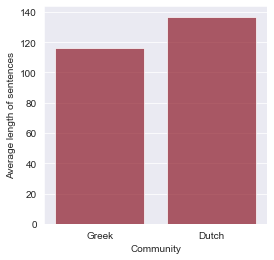

In [19]:
fig = plt.figure( figsize = ( 4,4 ))
sns.set_style("darkgrid")

ax = sns.barplot( x = ['Greek','Dutch'] , y = [length_greek,length_dutch] , alpha = 0.7,
                     color = '#a0061a'  ) 

ax.set_xlabel('Community')
ax.set_ylabel('Average length of sentences')

plt.show()



In [20]:
data = []

reviews = open(join(corpus_dir,'greek_max_tokens.txt'),encoding='utf-8')


for review in reviews:
    if re.search(r'\w+',review):
        row = dict()
        sentences = sent_tokenize(review)
        row['community'] = 'greek'
        row['nr_sentences'] = len(sentences)
        words = word_tokenize(review)
        words = [word for word in words if word not in punctuation_marks]
        row['nr_tokens'] = len(words)
        data.append(row)
        
reviews = open(join(corpus_dir,'dutch_max_tokens.txt'),encoding='utf-8')


for review in reviews:
    
    if re.search(r'\w+',review):
        row = dict()
        sentences = sent_tokenize(review)
        row['community'] = 'dutch'
        row['nr_sentences'] = len(sentences)
        words = word_tokenize(review)
        words = [word for word in words if word not in punctuation_marks]
        row['nr_tokens'] = len(words)
        data.append(row)
        
df = pd.DataFrame(data)
df_sum  = df.groupby('community').sum()
df_sum['sentence_length'] = df_sum['nr_tokens'] / df_sum['nr_sentences']
df_avg  = df.groupby('community')['nr_sentences'].mean()

In [21]:
df_sum.index

Index(['dutch', 'greek'], dtype='object', name='community')

In [22]:
x_axis = df_sum.index
y_axis = df_sum.sentence_length

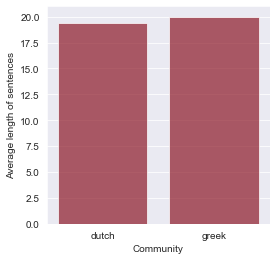

In [23]:
fig = plt.figure( figsize = ( 4,4 ))
sns.set_style("darkgrid")

ax = sns.barplot( x = x_axis , y = y_axis , alpha = 0.7,
                     color = '#a0061a'  ) 

ax.set_xlabel('Community')
ax.set_ylabel('Average length of sentences')

plt.show()



## Sentiment Analysis


In [24]:
data = []

nr_sentences = 0
count_positive = 0
count_negative = 0
dutch_sentences = dict()

path = os.path.join(corpus_dir,'dutch_max_tokens.txt')
text = open(path,encoding='utf-8')
full_text = text.read()
sentences = sent_tokenize(full_text)
for sentence in sentences:
    scores = ana.polarity_scores(sentence)
    nr_sentences += 1
    if scores['compound'] > 0.5:
        count_positive+=1
    elif scores['compound'] < -0.5:
        count_negative+=1

    dutch_sentences[sentence] = scores['compound']
    

count_neutral = nr_sentences - count_positive-count_negative
data.append( ['Dutch',count_neutral/nr_sentences,count_positive/nr_sentences,count_negative/nr_sentences] )

In [25]:
nr_sentences = 0
count_positive = 0
count_negative = 0
greek_sentences = dict()

path = os.path.join(corpus_dir,'greek_max_tokens.txt')
text = open(path,encoding='utf-8')
full_text = text.read()
sentences = sent_tokenize(full_text)
for sentence in sentences:
    scores = ana.polarity_scores(sentence)
    nr_sentences += 1
    if scores['compound'] > 0.5:
        count_positive+=1
    elif scores['compound'] < -0.5:
        count_negative+=1

    greek_sentences[sentence] = scores['compound']
    

count_neutral = nr_sentences - count_positive-count_negative
data.append( ['Greek',count_neutral/nr_sentences,count_positive/nr_sentences,count_negative/nr_sentences] )

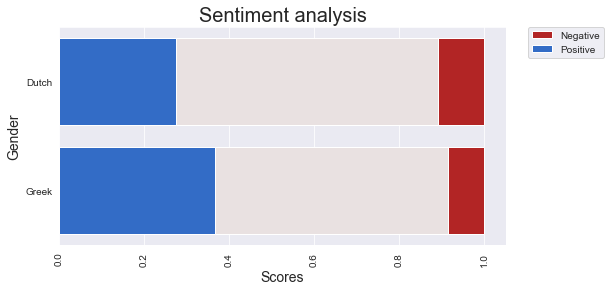

In [26]:
df = pd.DataFrame(data,columns=['nationality','neutral','positive','negative'])

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


y_axis = 'nationality'

fig = plt.figure( figsize=( 8 , 4 ) )

df['combined'] = df['positive'] + df['neutral'] + df['negative']
graph = sns.barplot( data=df , x='combined', y=y_axis , label = 'Negative', color = '#c90e0e' )
df['combined'] = df['combined'] - df['negative']
graph = sns.barplot( data=df , x='combined', y=y_axis , color = '#ebdfdf')
df['combined'] = df['combined'] - df['neutral']
graph = sns.barplot( data=df , x='combined', y=y_axis , label = 'Positive' ,color = '#1b66de')

graph.set_title('Sentiment analysis' , size = 20) 
graph.set_xlabel('Scores' , size = 14) 
graph.set_ylabel('Gender' , size = 14 )

plt.xticks(rotation= 90)

# The next line places the legend outside out the plot
plt.legend( bbox_to_anchor=(1.05, 1),loc=2, borderaxespad=0.);

plt.show()

In [27]:
def sorted_by_value( dict , ascending = True ):
    if ascending: 
        return {k: v for k, v in sorted(dict.items(), key=lambda item: item[1])}
    else:
        return {k: v for k, v in reversed( sorted(dict.items(), key=lambda item: item[1]))}


for i,sentence in enumerate(sorted_by_value(dutch_sentences)):
    if i< 15:
        print(f"{sentence}\n{dutch_sentences[sentence]}")
    else:
        break

The book touches on practically all present day social problems and issues: poverty, racism, misunderstanding and hatred between different religions and cultures, loneliness, old people struggling to find their place and value in society, dementia, the jewish problem (past and present), muslim radicalism, social security, invalidity, unemployment, violence, child abuse, rape.
-0.9895
So it can all be seen as play: the talk of blood sacrifices, the talk of war and destroying enemies, the racism, the misogyny, the arrogance and lack of pity towards the poor and suffering, the adoration of "hell" and "evil".
-0.9856
Life was actually quite rotten, really, but hardly anyone ever worried about death, even though some terminal diseases can be just as painful a way to die as a bomb or a bullet.
-0.9765
The first is, in short, about all sorts of different ways that the N-word can be used: “As we have seen, nigger can mean many different things, depenging upon, among other variables, intonation

In [28]:
for i,sentence in enumerate(sorted_by_value(greek_sentences)):
    if i< 15:
        print(f"{sentence}\n{greek_sentences[sentence]}")
    else:
        break

This is raw and hard as heck and I beg you to check out detailed trigger warnings for this book, with the ones I find prominent being (view spoiler)[ self-harm, suicide and suicidal thoughts, severe mental health issues, child sexual abuse, child prostitution (hide spoiler)] After getting that out of the way, this is an absolutely heartbreaking story of people hurting people either willingly or due to ignorance, it's a story full of all kinds of abuse, it's a story of friendships gone either very right or very wrong, a story that fills you with emptiness, sadness, the certainty that everything is awful, corrupted and pointless when there's so much hurting in this life!Literally you just read through the protagonist's life thinking "oh, come on, what more absolute tragedy can possibly strike this one (1) person throughout one (1) lifetime?"
-0.9934
(view spoiler)[ If only Marcus had taken his wife with him in England, and hadn't chose to stay in a country that had no future at all, his 

## Named Entity Recognition

In [29]:
nlp = stanza.Pipeline(lang='en', processors='tokenize,ner')

2024-06-24 08:58:10 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | combined  |
| ner       | ontonotes |

2024-06-24 08:58:10 INFO: Use device: cpu
2024-06-24 08:58:10 INFO: Loading: tokenize
2024-06-24 08:58:10 INFO: Loading: ner
2024-06-24 08:58:11 INFO: Done loading processors!


In [30]:
works_of_art_dutch = []
organisations_dutch = []
locations_dutch = []

reviews = open(join(corpus_dir,'dutch.txt'),encoding='utf-8')
for review in tqdm(reviews):
    doc = nlp(review)
    for ent in doc.ents:
        ent.text = re.sub(r'[\"\']','',ent.text)
        if ent.type == 'WORK_OF_ART':
            works_of_art_dutch.append(ent.text)
        elif ent.type == 'GPE':
            locations_dutch.append(ent.text)
        elif ent.type == 'ORG':
            organisations_dutch.append(ent.text)


2598it [48:53,  1.13s/it]


In [32]:
works_of_art_greek = []
organisations_greek = []
locations_greek = []

reviews = open(join(corpus_dir,'greek.txt'),encoding='utf-8')
for review in tqdm(reviews):
    doc = nlp(review)
    for ent in doc.ents:
        ent.text = re.sub(r'[\"\']','',ent.text)
        if ent.type == 'WORK_OF_ART':
            works_of_art_greek.append(ent.text)
        elif ent.type == 'GPE':
            locations_greek.append(ent.text)
        elif ent.type == 'ORG':
            organisations_greek.append(ent.text)

2737it [39:35,  1.15it/s]


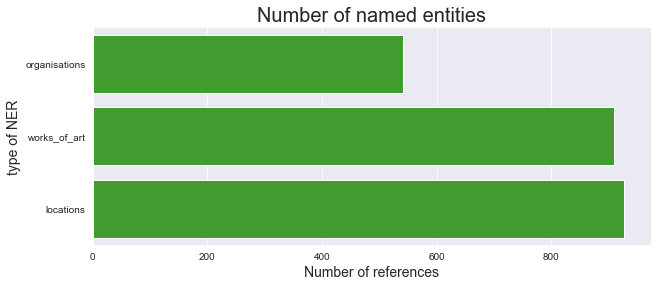

In [33]:
y_axis = ['organisations','works_of_art','locations']
x_axis = [len(organisations_dutch),len(works_of_art_dutch),len(locations_dutch)]


fig = plt.figure( figsize=( 10 , 4 ) )


graph = sns.barplot(y=y_axis,x=x_axis,color="#35ad1d")

graph.set_title(f'Number of named entities' , size = 20) 
graph.set_xlabel('Number of references' , size = 14) 
graph.set_ylabel('type of NER' , size = 14 )

plt.show()


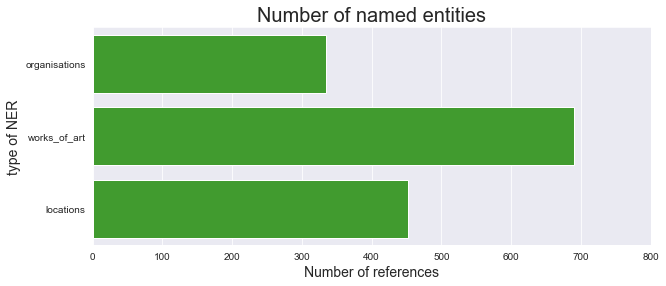

In [34]:
y_axis = ['organisations','works_of_art','locations']
x_axis = [len(organisations_greek),len(works_of_art_greek),len(locations_greek)]


fig = plt.figure( figsize=( 10 , 4 ) )


graph = sns.barplot(y=y_axis,x=x_axis,color="#35ad1d")

graph.set_title(f'Number of named entities' , size = 20) 
graph.set_xlabel('Number of references' , size = 14) 
graph.set_ylabel('type of NER' , size = 14 )

plt.xlim(0,800)

plt.show()


Which works of art do the Dutch reviewers refer to?

In [35]:
art_freq = Counter(works_of_art_dutch)
for work,count in art_freq.most_common(20):
    print(f"{work} ({count})")

Dog Soldiers (13)
Bible (13)
Goodreads (8)
The Last Samurai (8)
Little Women (8)
The Remains of the Day (6)
YA (6)
The Waste Land (6)
the Throne of Glass (5)
The Raven Boys (5)
Booker Prize (4)
Brideshead Revisited (4)
The Tempest (4)
Your Face Tomorrow (4)
The Great Gatsby (4)
All That Man Is (4)
A Little Life (4)
The Secret History (4)
An Ember in the Ashes (4)
The Selfish Gene (3)


Which works of art do the Greek reviewers refer to?

In [36]:
art_freq = Counter(works_of_art_greek)
for work,count in art_freq.most_common(20):
    print(f"{work} ({count})")

Goosebumps (24)
YA (18)
The Sandman (5)
The Stranger (4)
Goth Girl (4)
Arkham Asylum (4)
The Girl Next Door (4)
Off Season (4)
the Vampire Academy (4)
Gone Girl (4)
Astrology (4)
The Tunnel (3)
Vampire Academy (3)
Red Rising (3)
Winter Witch (3)
Unwritten (3)
Moon Called (3)
The Colour of Magic (3)
Through the Looking Glass (3)
Batman: Adventures (3)
